# 10-5-3 network decay tests

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [7]:
def ClassPlot(x, labels=[], idx=(1,2), equal=True):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    if equal:
        plt.axis('equal');

## Create a simple dataset

In [16]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 4896
# torch.manual_seed(seed)
# np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 0.91131208  0.58365258 -0.37373691 -0.5417517  -0.48147478 -1.05285549
   0.60676552  0.0359408   0.14132604  0.02924639]
 [ 1.19717405 -1.41145525  0.74374096 -1.27064268  1.33795296  0.22133336
   0.82820612 -0.195093    1.27147184 -0.63884136]
 [-1.2089337   0.19481817 -0.80332589 -0.47687836  0.26819165  0.95790865
   0.65269802  0.47479288 -1.25524529 -1.17704276]]


In [401]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [17]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [18]:
train = MakeDataset(A, B)

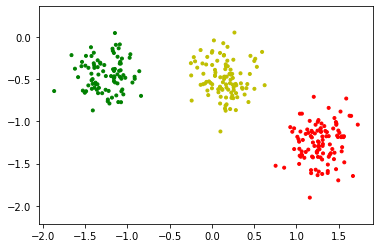

In [19]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

# Activity Decay Benefits Input Generation

In [20]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = True
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.02)
net.learning_tau = 0.1
net.learn_biases = False
net.learning_blackout=2.0

# Make two copies
net0 = deepcopy(net)
net1 = deepcopy(net)

net0.SetWeightDecay(0.0)
net0.SetvDecay(0.0)
net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
net1.SetWeightDecay(0.04)
net1.SetvDecay(0.0)
net1.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)

identity
identity


FloatProgress(value=0.0, max=3000.0)

FloatProgress(value=0.0, max=3000.0)

In [91]:
net.Save('untrained.net')
net0.Save('trained_no_decay.net')
net1.Save('trained_decay.net')

In [99]:
net = NN.NeuralNetwork(); net.Load('untrained.net')
net0 = NN.NeuralNetwork(); net0.Load('trained_no_decay.net')
net1 = NN.NeuralNetwork(); net1.Load('trained_decay.net')

In [21]:
num_classes = 3
input_dim = 10

classes = np.eye(3)
print(classes)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


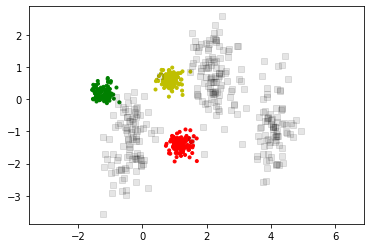

In [101]:
net.Allocate(train[0])
net.Reset(random=1.)
net.SetvDecay(0.)
z1 = net.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z1[:,idx[0]], z1[:,idx[1]], 's', color=(0,0,0,0.1));

In [113]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z1[train[0][:,coord]==1], dim=0)
    print(torch.sum(train[0][:,coord]==1))
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

tensor(102)
tensor(109)
tensor(89)
Avg std = tensor(0.7955)


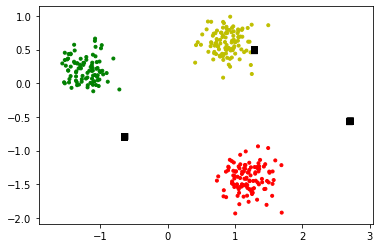

In [103]:
net.Allocate(train[0])
net.SetvDecay(0.01)
net.Reset(random=1.)
z1d = net.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z1d[:,idx[0]], z1d[:,idx[1]], 's', color=(0,0,0,0.1));

In [104]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z1d[train[0][:,coord]==1], dim=0)
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

Avg std = tensor(0.0048)


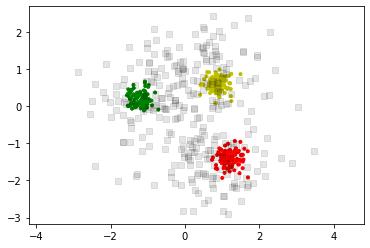

In [105]:
net0.Allocate(train[0])
net0.SetvDecay(0.)
net0.Reset(random=1.)
z2 = net0.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z2[:,idx[0]], z2[:,idx[1]], 's', color=(0,0,0,0.1));

In [106]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z2[train[0][:,coord]==1], dim=0)
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

Avg std = tensor(0.8173)


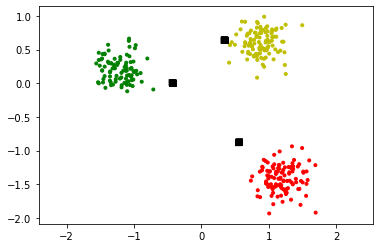

In [107]:
net0.Allocate(train[0])
net0.SetvDecay(0.01)
net0.Reset(random=1.)
z2d = net0.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z2d[:,idx[0]], z2d[:,idx[1]], 's', color=(0,0,0,0.1));

In [108]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z2d[train[0][:,coord]==1], dim=0)
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

Avg std = tensor(0.0048)


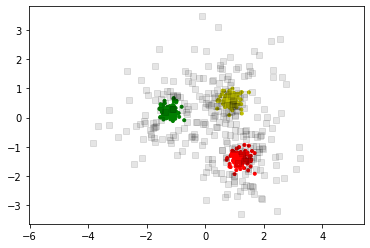

In [109]:
net1.Allocate(train[0])
net1.SetvDecay(0.)
net1.Reset(random=1.)
z3 = net1.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z3[:,idx[0]], z3[:,idx[1]], 's', color=(0,0,0,0.1));

In [110]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z3[train[0][:,coord]==1], dim=0)
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

Avg std = tensor(0.8233)


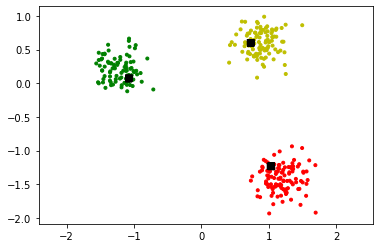

In [111]:
net1.Allocate(train[0])
net1.SetvDecay(0.01)
net1.Reset(random=1.)
z3d = net1.Predict(10., train[0], dt=0.001)
idx = (0,1)
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(z3d[:,idx[0]], z3d[:,idx[1]], 's', color=(0,0,0,0.1));

In [112]:
val = 0.
for coord in (0,1,2):
    blah = torch.std(z3d[train[0][:,coord]==1], dim=0)
    val += torch.sum(blah, dim=0)
print('Avg std = '+str(val/30.))

Avg std = tensor(0.0055)


In [704]:
generated_no_vdecay_decaynet = []
generated_no_vdecay_nodecaynet = []
generated_no_vdecay_initial = []

generated_yes_vdecay_decaynet = []
generated_yesvdecay_nodecaynet = []
generated_yes_vdecay_initial = []

net.Allocate(classes)
net0.Allocate(classes)
net1.Allocate(classes)

trials = 10
for i in range (0, trials):
    net.Reset()
    net.SetvDecay(0.05)
    net0.Reset()
    net0.SetvDecay(0.05)
    net1.Reset()
    net1.SetvDecay(0.05)
    
    initial_states = []
    for l in range(0, len(net0.layers)):
        initial_states.append(torch.randn_like(net0.layers[l].v).float().to(device))
        
    for l in range(0, len(net0.layers)):
        net.layers[l].v = initial_states[l]
        net0.layers[l].v = initial_states[l]
        net1.layers[l].v = initial_states[l]
    
    z1 = net.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    z2 = net0.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    z3 = net1.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)

    generated_yes_vdecay_initial.append(deepcopy(z1))
    generated_yes_vdecay_nodecaynet.append(deepcopy(z2))
    generated_yes_vdecay_decaynet.append(deepcopy(z3))
    
    net.Reset()
    net.SetvDecay(0.0)
    net0.Reset()
    net0.SetvDecay(0.0)
    net1.Reset()
    net1.SetvDecay(0.0)
    for l in range(0, len(net0.layers)):
        net.layers[l].v = initial_states[l]
        net0.layers[l].v = initial_states[l]
        net1.layers[l].v = initial_states[l]
    
    zz1 = net.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    zz2 = net0.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    zz3 = net1.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)

    generated_no_vdecay_initial.append(deepcopy(zz1))
    generated_no_vdecay_nodecaynet.append(deepcopy(zz2))
    generated_no_vdecay_decaynet.append(deepcopy(zz3))    

In [705]:
vd_wd_stds = []
nd_wd_stds = []

vd_nd_stds = []
nd_nd_stds = []

vd_stds = []
nd_stds = []

for j in range(num_classes):
    for k in range(input_dim):
        neuron1 = []
        neuron2 = []
        neuron3 = []
        neuron4 = []
        neuron5 = []
        neuron6 = []
        for i in range(trials):
            neuron1.append(generated_yes_vdecay_decaynet[i][j][k].item())
            neuron2.append(generated_no_vdecay_decaynet[i][j][k].item())
            neuron3.append(generated_yes_vdecay_nodecaynet[i][j][k].item())
            neuron4.append(generated_no_vdecay_nodecaynet[i][j][k].item())
            neuron5.append(generated_yes_vdecay_initial[i][j][k].item())
            neuron6.append(generated_no_vdecay_initial[i][j][k].item())
        
        vd_wd_stds.append(np.std(neuron1))
        nd_wd_stds.append(np.std(neuron2))
        vd_nd_stds.append(np.std(neuron3))
        nd_nd_stds.append(np.std(neuron4))
        vd_stds.append(np.std(neuron5))
        nd_stds.append(np.std(neuron6))

print(np.mean(vd_wd_stds))
print(np.mean(nd_wd_stds))
print(np.mean(vd_nd_stds))
print(np.mean(nd_nd_stds))
print(np.mean(vd_stds))
print(np.mean(nd_stds))

0.004991055185925427
0.7416690091058638
1.0199411269362562
51.80489903004832
2.582333797391832
359.58316916528014


In [707]:
print(np.mean(nd_wd_stds)/np.mean(vd_wd_stds))
print(np.mean(nd_nd_stds)/np.mean(vd_nd_stds))
print(np.mean(nd_stds)/np.mean(vd_stds))

148.5996410533268
50.79204834661599
139.2473620290532


In [ ]:
correct = 0
z = net0.BackprojectExpectation(train[1])
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(np.asarray(train[0].cpu()), 1)
correct = np.count_nonzero((np.asarray(y_classes) - t_classes)==0)
print('with decay net test set accuracy: {rate}'.format(rate=(correct / len(train[1]))))

In [709]:
correct = 0
z = net1.BackprojectExpectation(train[1])
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(np.asarray(train[0].cpu()), 1)
correct = np.count_nonzero((np.asarray(y_classes) - t_classes)==0)
print('with decay net test set accuracy: {rate}'.format(rate=(correct / len(train[1]))))

with decay net test set accuracy: 1.0


In [715]:
corr = 0

for i in range(trials):
    z2 = generated_yes_vdecay_initial[i]
    
    for j in range(num_classes):    
        corr += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
print(corr / 30)

-0.30796762664228905


# Weight Decay Benefits Training

In [503]:
net_nodecay = []

net_decay = []

In [ ]:
num_networks=10
for k in range(num_networks):
    net = NN.NeuralNetwork()
    net.AddLayer(Layer.InputPELayer(n=n_classes))
    net.AddLayer(Layer.PELayer(n=hidden_dim))
    net.AddLayer(Layer.TopPELayer(n=sensory_dim))

    sym = False
    af = 'identity'
    net.Connect(0, 1, act=af, symmetric=sym)
    net.Connect(1, 2, act=af, symmetric=sym)

    net.SetTau(0.02)
    net.learning_tau = 0.1
    net.learn_biases = False
    net.learning_blackout=2.0

    # Make two copies
    net0 = deepcopy(net)
    net1 = deepcopy(net)

    net0.SetWeightDecay(0.0)
    net0.SetvDecay(0.0)
    net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net1.SetWeightDecay(0.05)
    net1.SetvDecay(0.0)
    net1.Learn(train[0], train[1], T=5., dt=0.001, epochs=10, batch_size=20)
    
    net_nodecay.append(net0)
    net_decay.append(net1)

identity
identity


FloatProgress(value=0.0, max=3000.0)

FloatProgress(value=0.0, max=3000.0)

identity
identity


FloatProgress(value=0.0, max=3000.0)

In [691]:
generated_nodecay_net = []
generated_decay_net = []

for i in range (0, len(net_nodecay)):
    net0 = net_nodecay[i]
    net1 = net_decay[i]
    
    net0.Reset()
    net0.SetvDecay(0.02)
    net1.Reset()
    net1.SetvDecay(0.02)
    
    y2 = net0.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)
    y3 = net1.Predict(10., torch.tensor(classes).float().to(device), dt=0.001)

    generated_nodecay_net.append(deepcopy(y2))
    generated_decay_net.append(deepcopy(y3))

In [692]:
#Calculate average, minimum, and maximum cosine similarity for decay networks
norm_corr_sum = 0
minimum_corr =  180
max_corr = -179

for i in range(0, num_networks):
    z2 = generated_decay_net[i]    
    corr = 0
    
    for j in range (0, num_classes): 
        corr += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
    norm_corr_sum += corr
    corr /= 3
    
    if corr < minimum_corr:
            minimum_corr = corr
    if corr > max_corr:
            max_corr = corr
        
print(norm_corr_sum / (num_networks*3))
print(minimum_corr)
print(max_corr)

0.9920252365580632
0.9890600913708255
0.9944983796189589


In [693]:
#Calculate average, minimum, and maximum cosine similarity for decay networks

norm_corr_sum = 0
minimum_corr =  180
max_corr = -179

for i in range(0, num_networks):
    z2 = generated_nodecay_net[i]    
    corr = 0
    
    for j in range (0, num_classes):
        corr += np.dot(z2[j].cpu(), A[j]) / (np.linalg.norm(z2[j].cpu())*np.linalg.norm(A[j]))
        
    norm_corr_sum += corr
    corr /= 3
    
    if corr < minimum_corr:
        minimum_corr = corr
    if corr > max_corr:
        max_corr = corr

        
print(norm_corr_sum / (num_networks*3))
print(minimum_corr)
print(max_corr)

-0.12923977426746083
-0.4052940488132692
0.2574039234693812


In [699]:
zz2 = generated_decay_net[0]
zz3 = generated_nodecay_net[0]

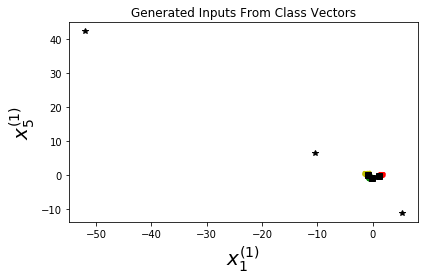

In [700]:
lgnd = ['Weight Decay Training', 'No Weight Decay Training'] #['NoWD NoAD', 'YesWD NoAD', 'YesWD YesAD']

idx=(8,3)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx, equal=False)
plt.plot(np.array(zz2[:,idx[0]].cpu()), np.array(zz2[:,idx[1]].cpu()), 'ks');
plt.plot(np.array(zz3[:,idx[0]].cpu()), np.array(zz3[:,idx[1]].cpu()), 'k*');
plt.xlabel('$x_1^{(1)}$', fontsize=20)
plt.ylabel('$x_5^{(1)}$', fontsize=20)
plt.legend(lgnd)
#plt.ylim((-1.5,1.0))
#plt.xlim((-1.5, 2.0))
plt.title('Generated Inputs From Class Vectors')
plt.tight_layout()
#plt.savefig("no_activity_decay_during_testing.pdf", format='pdf')

a = plt.axis()